# Setup

## Imports

In [1]:
using Pkg
Pkg.activate("SCC", shared=true)


import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

  Activating project at `~/.julia/environments/SCC`
[ Info: new driver key :netcdf, updating backendlist.


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), Info, Base.CoreLogging.default_metafmt, true, 0, Dict{Any, Int64}())

# Loading Model and json

## Making Model

In [3]:
#Readout = SC.Circuits.Transmon_Resonators.load("ModelSaves/Readout/Readout.json");
#Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");
#proj_dict = SC.Utils.Get_Projection_Ops(Readout.dressed_states);

#device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

#println(SC.Utils.tostr(Mode3.params))

In [4]:
# E_C = Mode3.params["E_C"]
# E_J = Mode3.params["E_J"]
# E_oscs = [Readout.params["E_oscs"][1], Mode3.params["E_oscs"][1]]

# gs = [Mode3.params["gs"][1], Readout.params["gs"][1]]
# Nrs = [10, 10]
# Nt = 10

# Cavity_Names = ["Mode3", "Readout"]

# Save_Path = "ModelSaves/ReadoutMode3/"
# Model_Name = "ReadoutMode3"

# Model = SC.Circuits.Transmon_Resonators.init(E_C, E_J, E_oscs, gs, Nt, Nrs, Cavity_Names = Cavity_Names, Save_Path = Save_Path, Model_Name = Model_Name);


## Loading Model

In [5]:
Model = SC.Circuits.Transmon_Resonators.load("ModelSaves/ReadoutMode3/ReadoutMode3.json");

In [6]:
GLOBAL_SAVE_CALIBRATE = true;

In [7]:
SC.Utils.save_model(Model)

In [8]:
println(SC.Utils.tostr(Model.Stuff["op_drive_params"]["f00g01"]))

Dict{String, Any} with 7 entries:
  "pulse_time" => 315.159
  "Envelope Args" => Dict{String, Any}("pulse_time"=>315.159, "k"=>2, "ramp_time"=>10)
  "epsilon" => 0.15
  "Envelope" => "Bump_Ramp"
  "shift" => 0.00153925
  "accuracy" => 0.99987
  "freq_d" => -2.83569


In [9]:
Model.Stuff["op_drive_params"]["6_us_wait"] = Dict{Any, Any}("pulse_time" => 6000, "epsilon" => 0, "shift" => 0, "Envelope" => "Square", "Envelope Args" => Dict{Any, Any}(), "freq_d" => 0)

Dict{Any, Any} with 6 entries:
  "pulse_time"    => 6000
  "Envelope Args" => Dict{Any, Any}()
  "epsilon"       => 0
  "shift"         => 0
  "Envelope"      => "Square"
  "freq_d"        => 0

# Calibrating Pulses

For this, I am trying to calibrate pulses of equal length for each fock state in order to make a frequency comb! Targeting 300ns.

## $|f00\rangle \to |g01\rangle$

[2024-12-06 17:33:53] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


[2024-12-06 17:34:40] Info: Done With Floquet Sweep
[2024-12-06 17:34:40] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0009720254754065678	 0.0012954781663967647	 2.003234342197966


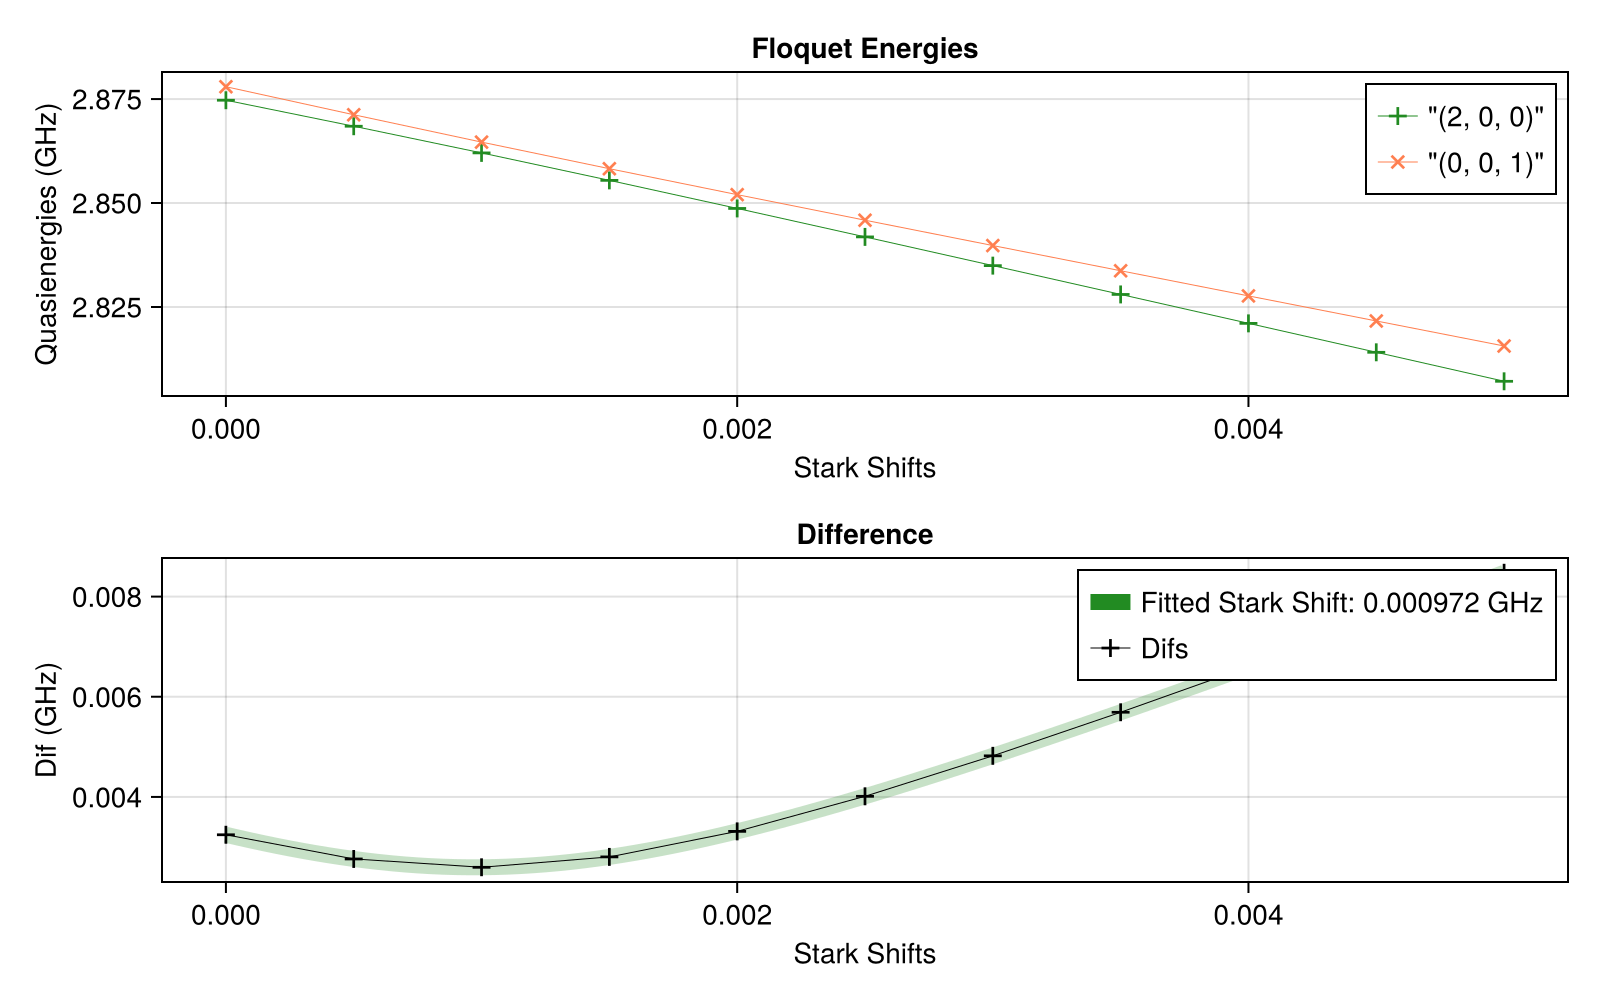

In [86]:
state1 = (2,0,0)
state2 = (0,0,1)

ψi = Model.dressed_states[state1];
ψf = Model.dressed_states[state2];


freq_d = Model.dressed_energies[state2]-Model.dressed_energies[state1];
ε = 0.119;

stark_shift_list = collect(LinRange(0, 0.005, 11));

f00g01_ss = SC.Dynamics.FindStarkShift(Model, state1, state2, ε, stark_shift_list);

In [87]:
f00g01_ss

2-element Vector{Float64}:
   0.0009720254754065678
 385.33472265990315

In [88]:
ψ1 = Model.dressed_states[state1];
ψ2 = Model.dressed_states[state2];

envelope = "Bump_Ramp"
envelope_args = Dict("ramp_time" => 10, "pulse_time" => 0.0, "k" => 2)

t_range = [f00g01_ss[2], f00g01_ss[2]+2*envelope_args["ramp_time"]]

f00g01_pulse_opt_res = SC.Dynamics.OptimizePulse(Model, ψ1, ψ2, ε, freq_d, f00g01_ss[1], t_range, envelope, envelope_args, levels=1)

[2024-12-06 17:34:40] Info: On Level 1
[2024-12-06 17:34:40] Info: On Step 1: t = 385.33472265990315
[2024-12-06 17:34:40] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 21s (ETA: 0h 00m 00s)
[2024-12-06 17:35:02] Info: Time Evolution Complete
[2024-12-06 17:35:02] Info: Done with Level_1_step_1
[2024-12-06 17:35:02] Info: Accurace: 0.9981554447181016
[2024-12-06 17:35:02] Info: ------------------------------------------------------------------------------
[2024-12-06 17:35:02] Info: On Step 2: t = 390.33472265990315
[2024-12-06 17:35:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 21s (ETA: 0h 00m 00s)
[2024-12-06 17:35:24] Info: Time Evolution Complete
[2024-12-06 17:35:24] Info: Done with Level_1_step_2
[2024-12-06 17:35:24] Info: Accurace: 0.9994265702999576
[2024-12-06 17:35:24] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 395.335
  "Envelope Args" => Dict{String, Real}("pulse_time"=>395.335, "k"=>2, "ramp_ti…
  "epsilon"       => 0.119
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000972025
  "accuracy"      => 0.999868
  "freq_d"        => -2.83569

In [89]:
Model.Stuff["op_drive_params"]["f00g01"] = f00g01_pulse_opt_res;

In [90]:
#SC.Utils.save_model(Model)

## $|f10\rangle \to |g11\rangle$

[2024-12-06 17:36:31] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[2024-12-06 17:37:22] Info: Done With Floquet Sweep
[2024-12-06 17:37:22] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0009555375941379041	 0.0012842921030477219	 2.0031793214734344


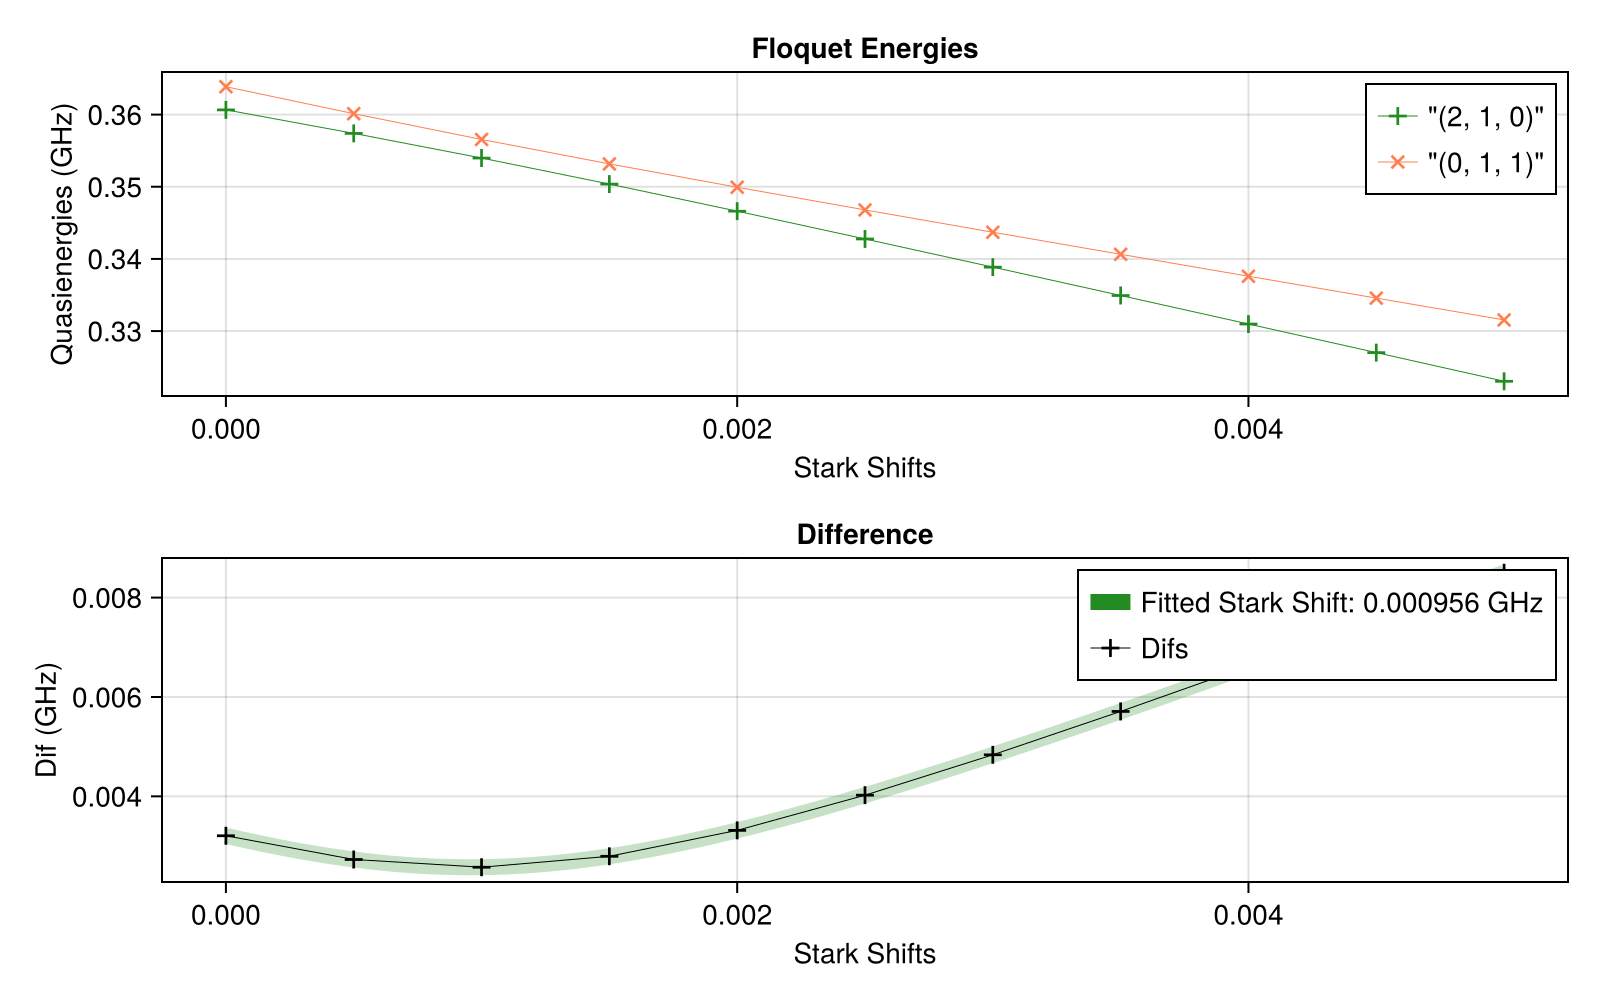

In [91]:
state1 = (2,1,0)
state2 = (0,1,1)

ψi = Model.dressed_states[state1];
ψf = Model.dressed_states[state2];


freq_d = Model.dressed_energies[state2]-Model.dressed_energies[state1];
ε = 0.118;

#stark_shift_list = collect(LinRange(0, 0.1, 11));
stark_shift_list = collect(LinRange(0, 0.005, 11));

f10g11_ss = SC.Dynamics.FindStarkShift(Model, state1, state2, ε, stark_shift_list);

In [92]:
f10g11_ss

2-element Vector{Float64}:
   0.0009555375941379041
 388.70162788687287

In [93]:
state1 = (2,1,0)
state2 = (0,1,1)

ψ1 = Model.dressed_states[state1];
ψ2 = Model.dressed_states[state2];

envelope = "Bump_Ramp"
envelope_args = Dict("ramp_time" => 10, "pulse_time" => 0.0, "k" => 2)

t_range = [f10g11_ss[2], f10g11_ss[2]+2*envelope_args["ramp_time"]]

f10g11_pulse_opt_res = SC.Dynamics.OptimizePulse(Model, ψ1, ψ2, ε, freq_d, f10g11_ss[1], t_range, envelope, envelope_args, levels = 1)

[2024-12-06 17:37:22] Info: On Level 1
[2024-12-06 17:37:22] Info: On Step 1: t = 388.70162788687287
[2024-12-06 17:37:22] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 22s (ETA: 0h 00m 00s)
[2024-12-06 17:37:45] Info: Time Evolution Complete
[2024-12-06 17:37:45] Info: Done with Level_1_step_1
[2024-12-06 17:37:45] Info: Accurace: 0.9983129197677635
[2024-12-06 17:37:45] Info: ------------------------------------------------------------------------------
[2024-12-06 17:37:45] Info: On Step 2: t = 393.70162788687287
[2024-12-06 17:37:45] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 22s (ETA: 0h 00m 00s)
[2024-12-06 17:38:07] Info: Time Evolution Complete
[2024-12-06 17:38:07] Info: Done with Level_1_step_2
[2024-12-06 17:38:07] Info: Accurace: 0.999563784020809
[2024-12-06 17:38:07] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 398.702
  "Envelope Args" => Dict{String, Real}("pulse_time"=>398.702, "k"=>2, "ramp_ti…
  "epsilon"       => 0.118
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000955538
  "accuracy"      => 0.999999
  "freq_d"        => -2.83552

In [94]:
Model.Stuff["op_drive_params"]["f10g11"] = f10g11_pulse_opt_res;

## $|f20\rangle \to |g21\rangle$

[2024-12-06 17:39:16] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[2024-12-06 17:40:10] Info: Done With Floquet Sweep
[2024-12-06 17:40:10] Info: Fit Stuff: 3-element Vector{Float64}:	 0.000939193430769557	 0.0012731107691352744	 2.0031247924740616


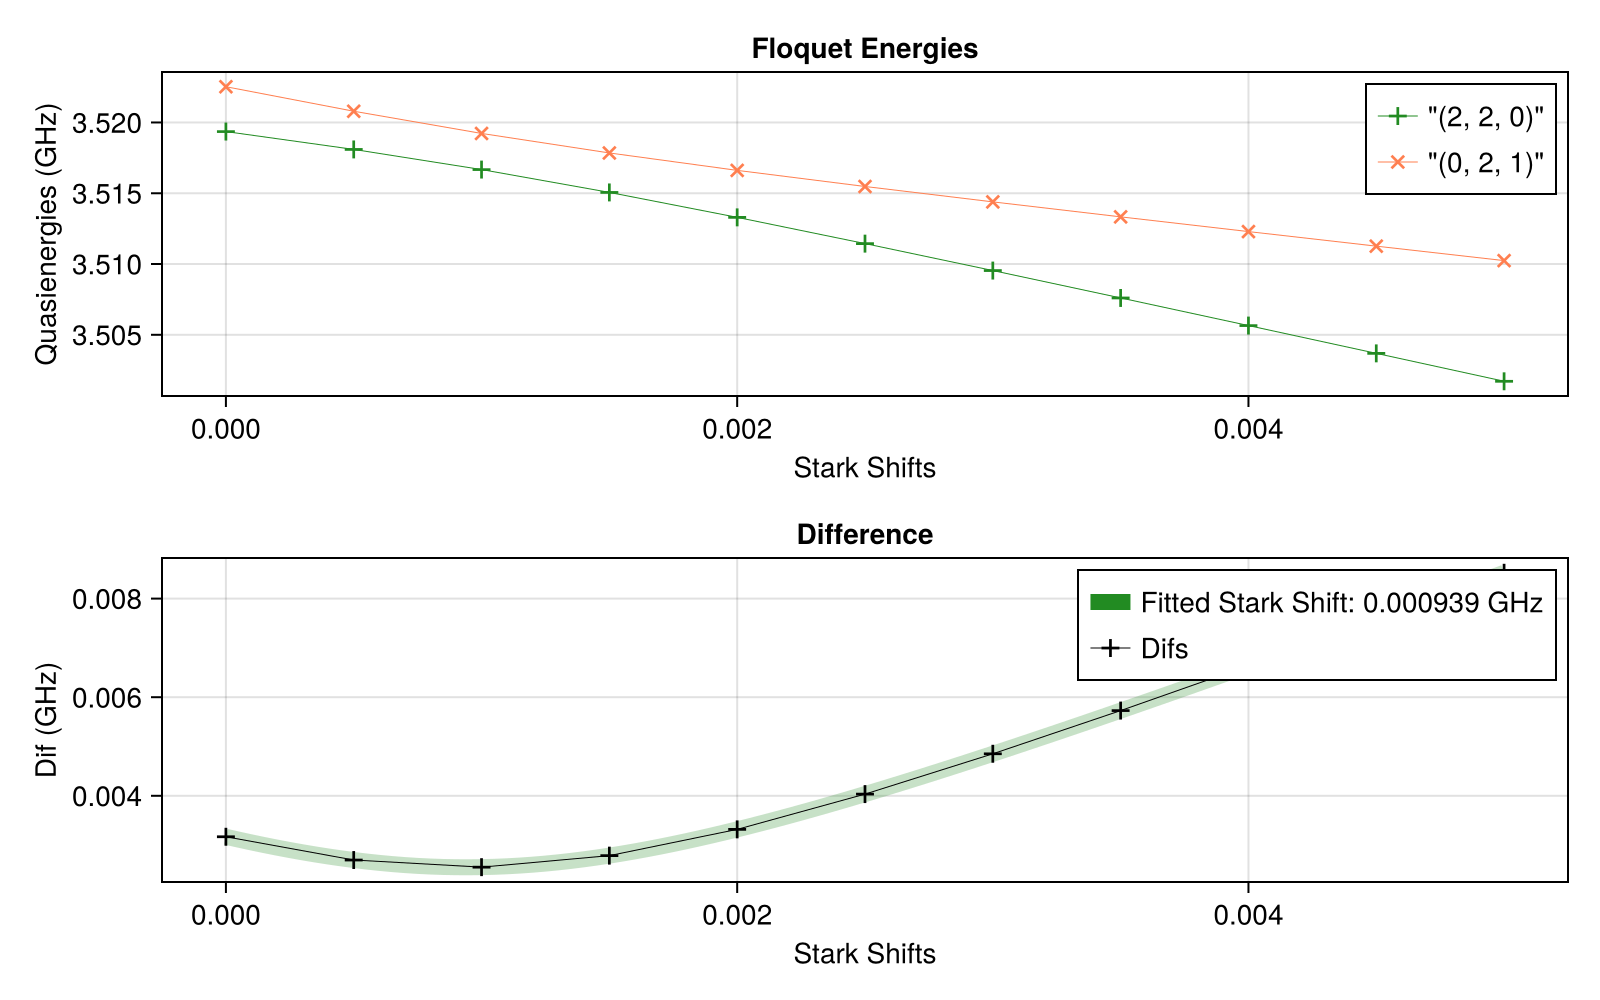

In [95]:
state1 = (2,2,0)
state2 = (0,2,1)

ψi = Model.dressed_states[state1];
ψf = Model.dressed_states[state2];


freq_d = Model.dressed_energies[state2]-Model.dressed_energies[state1];
ε = 0.117;

stark_shift_list = collect(LinRange(0, 0.005, 11));

f20g21_ss = SC.Dynamics.FindStarkShift(Model, state1, state2, ε, stark_shift_list);

In [96]:
f20g21_ss

2-element Vector{Float64}:
   0.000939193430769557
 392.1261469318753

In [97]:
state1 = (2,2,0)
state2 = (0,2,1)

ψ1 = Model.dressed_states[state1];
ψ2 = Model.dressed_states[state2];

envelope = "Bump_Ramp"
envelope_args = Dict("ramp_time" => 10, "pulse_time" => 0.0, "k" => 2)

t_range = [f20g21_ss[2], f20g21_ss[2]+2*envelope_args["ramp_time"]]

f20g21_pulse_opt_res = SC.Dynamics.OptimizePulse(Model, ψ1, ψ2, ε, freq_d, f20g21_ss[1], t_range, envelope, envelope_args, levels = 1)

[2024-12-06 17:40:10] Info: On Level 1
[2024-12-06 17:40:10] Info: On Step 1: t = 392.1261469318753
[2024-12-06 17:40:10] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 22s (ETA: 0h 00m 00s)
[2024-12-06 17:40:33] Info: Time Evolution Complete
[2024-12-06 17:40:33] Info: Done with Level_1_step_1
[2024-12-06 17:40:33] Info: Accurace: 0.9983428075105585
[2024-12-06 17:40:33] Info: ------------------------------------------------------------------------------
[2024-12-06 17:40:33] Info: On Step 2: t = 397.1261469318753
[2024-12-06 17:40:33] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 23s (ETA: 0h 00m 00s)
[2024-12-06 17:40:56] Info: Time Evolution Complete
[2024-12-06 17:40:56] Info: Done with Level_1_step_2
[2024-12-06 17:40:56] Info: Accurace: 0.9995719451419205
[2024-12-06 17:40:56] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 402.126
  "Envelope Args" => Dict{String, Real}("pulse_time"=>402.126, "k"=>2, "ramp_ti…
  "epsilon"       => 0.117
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000939193
  "accuracy"      => 1.0
  "freq_d"        => -2.83534

In [98]:
Model.Stuff["op_drive_params"]["f20g21"] = f20g21_pulse_opt_res;

## $|f30\rangle \to |g31\rangle$

[2024-12-06 17:42:12] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


[2024-12-06 17:43:03] Info: Done With Floquet Sweep
[2024-12-06 17:43:03] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0009229944294160165	 0.0012619341241220292	 2.0030707510765255


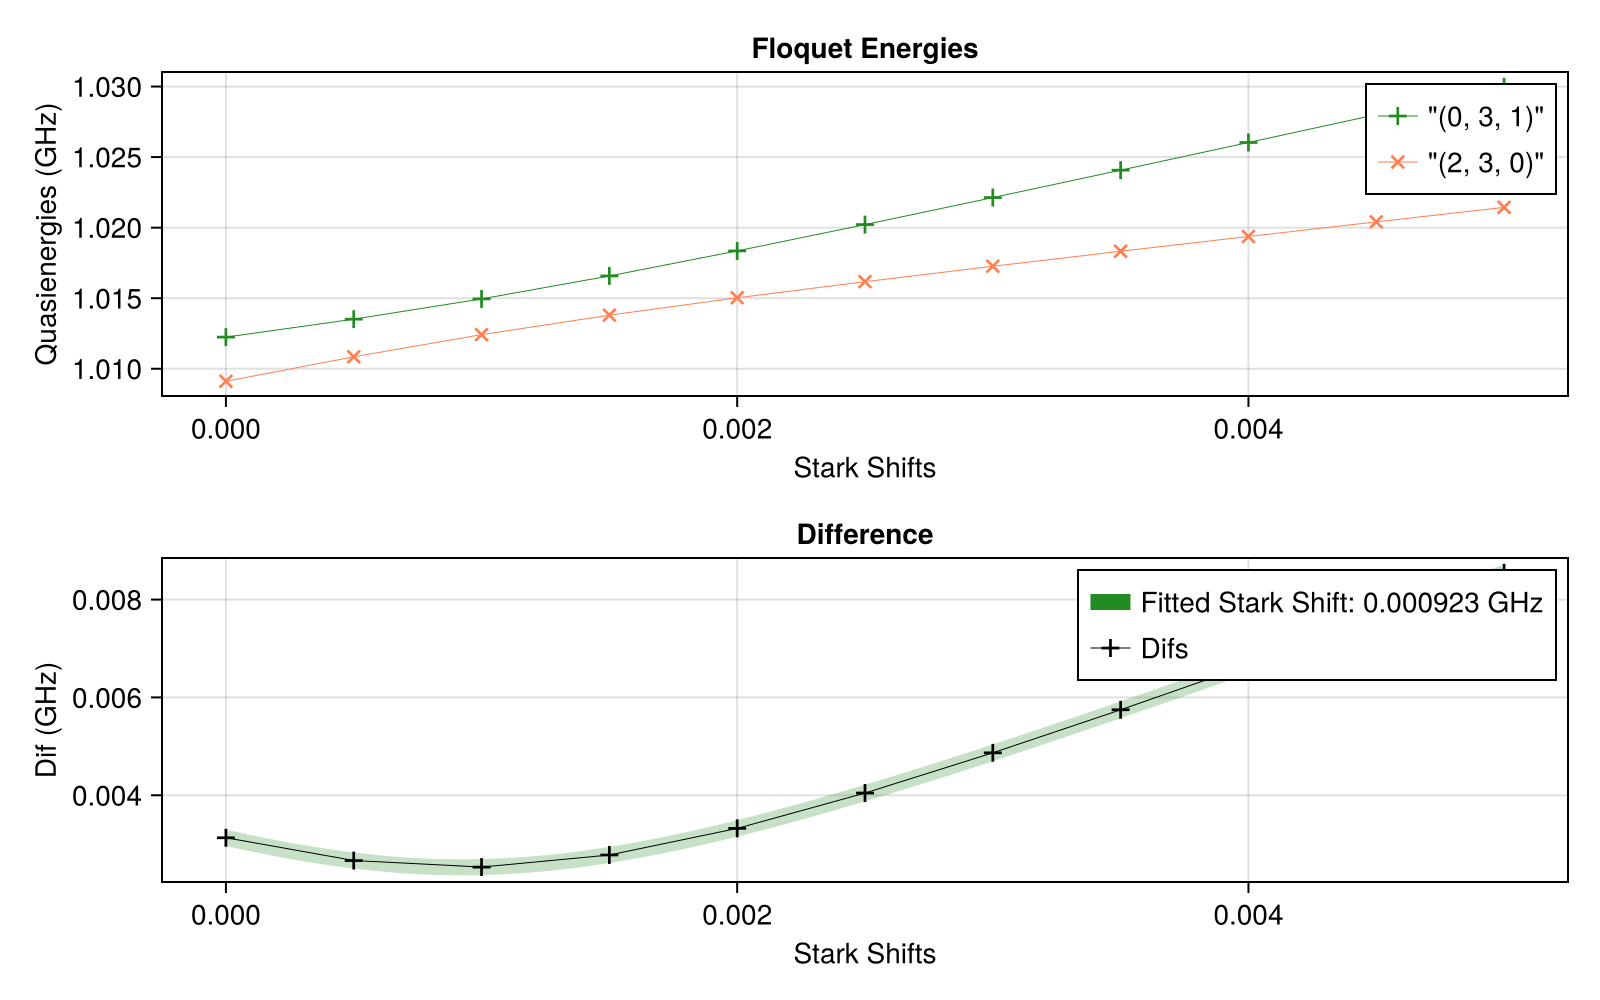

In [99]:
state1 = (2,3,0)
state2 = (0,3,1)

ψi = Model.dressed_states[state1];
ψf = Model.dressed_states[state2];


freq_d = Model.dressed_energies[state2]-Model.dressed_energies[state1];
ε = 0.116;

stark_shift_list = collect(LinRange(0, 0.005, 11));

f30g31_ss = SC.Dynamics.FindStarkShift(Model, state1, state2, ε, stark_shift_list);

In [100]:
f30g31_ss

2-element Vector{Float64}:
   0.0009229944294160165
 395.6097862558937

In [101]:
state1 = (2,3,0)
state2 = (0,3,1)

ψ1 = Model.dressed_states[state1];
ψ2 = Model.dressed_states[state2];

envelope = "Bump_Ramp"
envelope_args = Dict("ramp_time" => 10, "pulse_time" => 0.0, "k" => 2)

t_range = [f30g31_ss[2], f30g31_ss[2]+2*envelope_args["ramp_time"]]

f30g31_pulse_opt_res = SC.Dynamics.OptimizePulse(Model, ψ1, ψ2, ε, freq_d, f30g31_ss[1], t_range, envelope, envelope_args, levels = 1)

[2024-12-06 17:43:03] Info: On Level 1
[2024-12-06 17:43:03] Info: On Step 1: t = 395.6097862558937
[2024-12-06 17:43:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 22s (ETA: 0h 00m 00s)
[2024-12-06 17:43:26] Info: Time Evolution Complete
[2024-12-06 17:43:26] Info: Done with Level_1_step_1
[2024-12-06 17:43:26] Info: Accurace: 0.9983718022443856
[2024-12-06 17:43:26] Info: ------------------------------------------------------------------------------
[2024-12-06 17:43:26] Info: On Step 2: t = 400.6097862558937
[2024-12-06 17:43:26] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 22s (ETA: 0h 00m 00s)
[2024-12-06 17:43:49] Info: Time Evolution Complete
[2024-12-06 17:43:49] Info: Done with Level_1_step_2
[2024-12-06 17:43:49] Info: Accurace: 0.999579407931883
[2024-12-06 17:43:49] Info: ------------------------------------------------------------------------------
[2024-

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 405.61
  "Envelope Args" => Dict{String, Real}("pulse_time"=>405.61, "k"=>2, "ramp_tim…
  "epsilon"       => 0.116
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000922994
  "accuracy"      => 1.0
  "freq_d"        => -2.83517

In [102]:
Model.Stuff["op_drive_params"]["f30g31"] = f30g31_pulse_opt_res;

## $|fn0\rangle \to |gn1\rangle$ Frequency Comb

## Lossless

In [108]:
νs = []
εs = [] 
shifts = [0.00, 0.00, 0.00, 0.0] # for 1/2
#shifts = [0.00, 0.00, 0.00, 0.0].+0.02 # for 1/sqrt(2)
for i in 0:3
    freq_d = Model.dressed_energies[(0,i,1)]-Model.dressed_energies[(2,i,0)]
    push!(νs,  Model.Stuff["op_drive_params"]["f$(i)0g$(i)1"]["freq_d"]+Model.Stuff["op_drive_params"]["f$(i)0g$(i)1"]["shift"]+shifts[i+1])
    push!(εs,  Model.Stuff["op_drive_params"]["f$(i)0g$(i)1"]["epsilon"]/2)
end

# for i in 0:3
#    freq_d = Model.dressed_energies[(0,i,1)]-Model.dressed_energies[(2,i,0)]
#    push!(νs,  freq_d+Model.Stuff["op_drive_params"]["f10g11"]["shift"]+shifts[i+1])
#    push!(εs,  Model.Stuff["op_drive_params"]["f10g11"]["epsilon"]/2)
# end


In [109]:
ψi = Model.dressed_states[(2,0,0)]+Model.dressed_states[(2,1,0)]+Model.dressed_states[(2,2,0)]+Model.dressed_states[(2,3,0)];
ψi = ψi/qt.norm(ψi);

pt = Model.Stuff["op_drive_params"]["f10g11"]["pulse_time"]

drive_params = Dict("shift" => 0.0, "freq_d" => νs, "epsilon" => εs, "pulse_time"=>pt, "Envelope" => "Bump_Ramp", "Envelope Args" => Dict("ramp_time" => 10, "pulse_time" => pt, "k" => 2));
Model.Stuff["op_drive_params"]["fn0gn1_Comb"] = deepcopy(drive_params)

#drive_params = Dict("shift" => 0.0, "freq_d" => νs, "epsilon" => εs, "pulse_time"=>3000, "Envelope" => "Bump_Ramp", "Envelope Args" => Dict("ramp_time" => 10, "pulse_time" => 3000, "k" => 2));
#Model.Stuff["op_drive_params"]["fn0gn1_Comb_Long"] = deepcopy(drive_params)

Dict{String, Any} with 6 entries:
  "pulse_time"    => 398.702
  "Envelope Args" => Dict{String, Real}("pulse_time"=>398.702, "k"=>2, "ramp_ti…
  "epsilon"       => Any[0.0595, 0.059, 0.0585, 0.058]
  "shift"         => 0.0
  "Envelope"      => "Bump_Ramp"
  "freq_d"        => Any[-2.83472, -2.83456, -2.8344, -2.83424]

In [110]:
run_res = SC.Dynamics.RunSingleOperator(Model, ψi, Model.Stuff["op_drive_params"]["fn0gn1_Comb"])#, Model.Stuff["op_drive_params"]["f00g01"]);

[2024-12-06 17:48:29] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 22s (ETA: 0h 00m 00s)
[2024-12-06 17:48:51] Info: Time Evolution Complete
[2024-12-06 17:48:51] Info: Done with DEFAULT


Solution of time evolution
(return code: Success)
--------------------------
num_states = 1995
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [111]:
ψf = run_res.states[end];
println(abs(ψf'*Model.dressed_states[(0,0,1)])^2)
println(abs(ψf'*Model.dressed_states[(0,1,1)])^2)
println(abs(ψf'*Model.dressed_states[(0,2,1)])^2)
println(abs(ψf'*Model.dressed_states[(0,3,1)])^2)

0.10128115042289819
0.1088096200883242
0.11141567271117699
0.10872671168609546


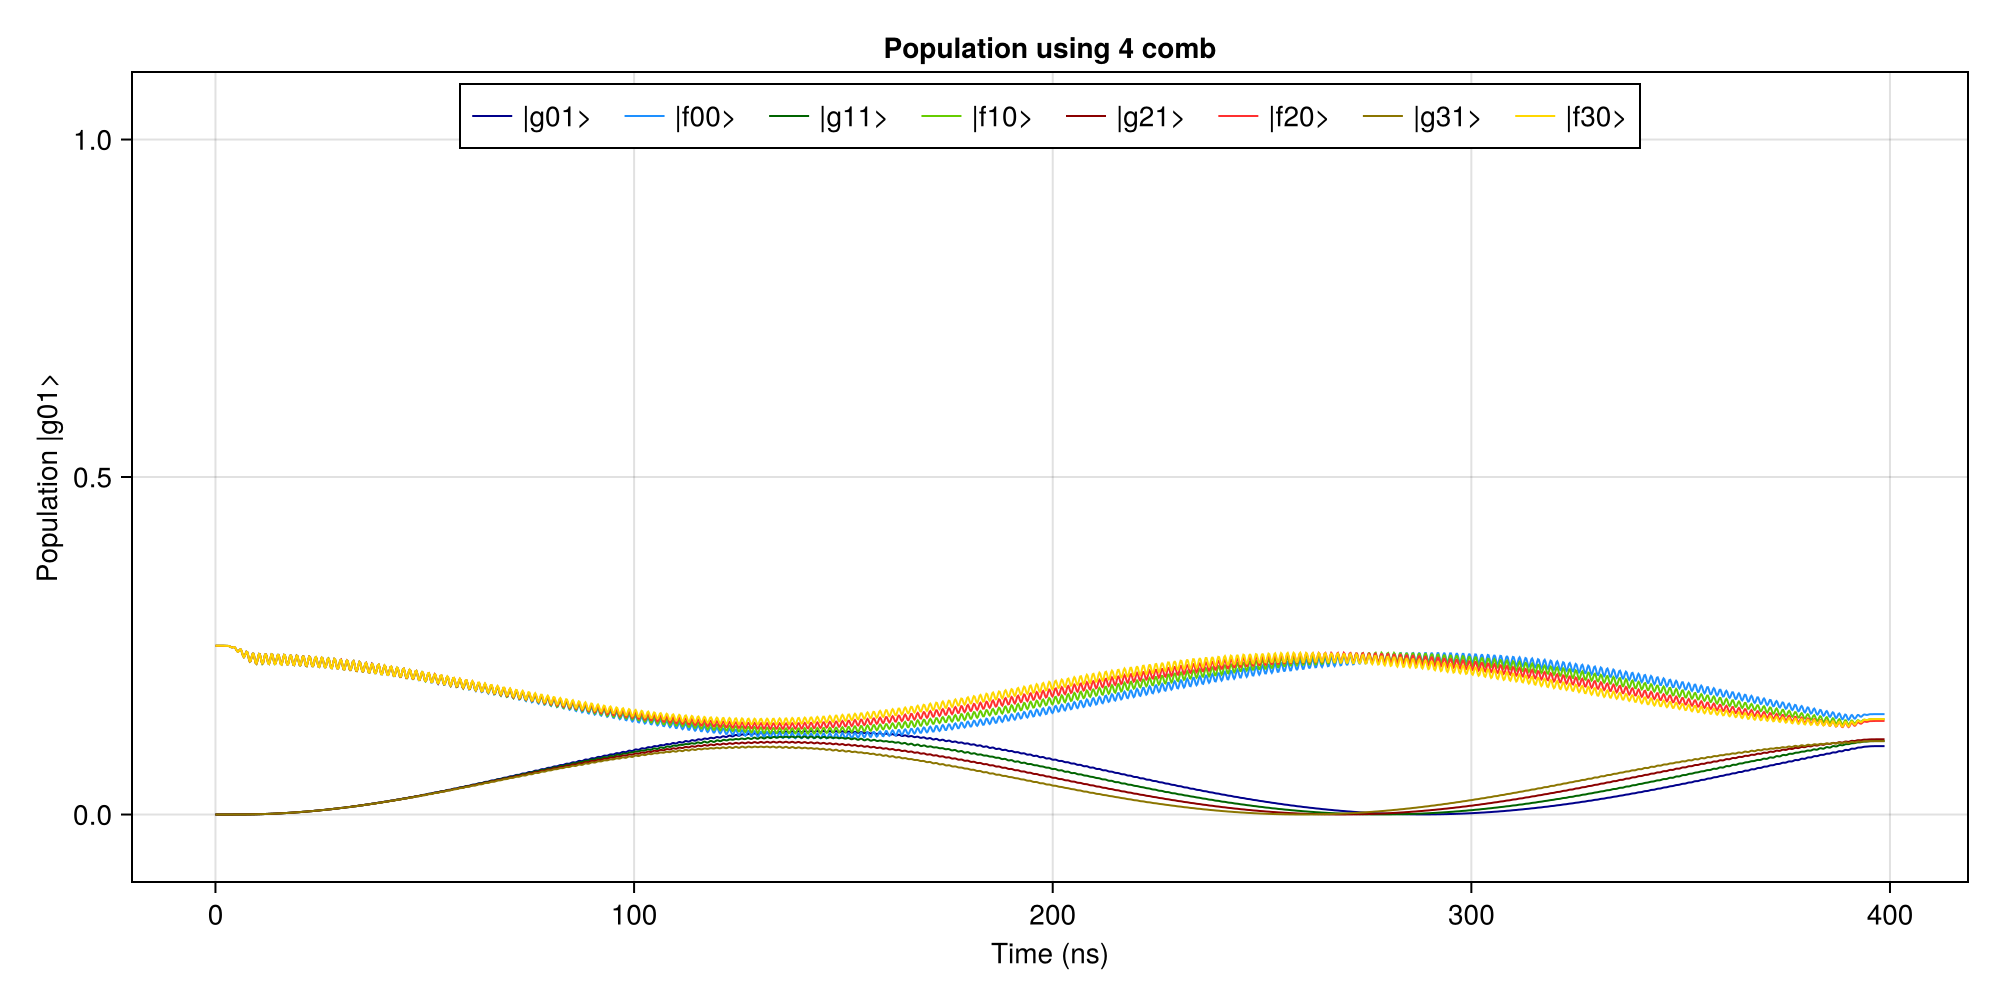

CairoMakie.Screen{IMAGE}


In [112]:
f = cm.Figure(size = (1000, 500))
ax = cm.Axis(f[1,1], title = "Population using 4 comb", xlabel = "Time (ns)", ylabel = "Population |g01>", limits = (nothing, (-0.1,1.1)))

ms = 0.1
lw = 1
alpha = 0.3
y = [abs(run_res.states[i]'*Model.dressed_states[(0,0,1)])^2 for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "darkblue", label = "|g01>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(run_res.states[i]'*Model.dressed_states[(2,0,0)])^2 for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "dodgerblue", label = "|f00>", markersize = ms, alpha = alpha, linewidth = lw)

y = [abs(run_res.states[i]'*Model.dressed_states[(0,1,1)])^2 for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "darkgreen", label = "|g11>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(run_res.states[i]'*Model.dressed_states[(2,1,0)])^2 for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "chartreuse3", label = "|f10>", markersize = ms, alpha = alpha, linewidth = lw)

y = [abs(run_res.states[i]'*Model.dressed_states[(0,2,1)])^2 for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "darkred", label = "|g21>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(run_res.states[i]'*Model.dressed_states[(2,2,0)])^2 for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "firebrick1", label = "|f20>", markersize = ms, alpha = alpha, linewidth = lw)

y = [abs(run_res.states[i]'*Model.dressed_states[(0,3,1)])^2 for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "gold4", label = "|g31>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(run_res.states[i]'*Model.dressed_states[(2,3,0)])^2 for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "gold", label = "|f30>", markersize = ms, alpha = alpha, linewidth = lw)


# y = [abs(run_res.states[i]'*Model.dressed_states[(1,0,0)])^2 for i in 1:length(run_res.states)]
# cm.scatterlines!(ax, run_res.times, y, color = "forestgreen", label = "|e00>", markersize = ms, alpha = alpha, linewidth = lw)
# y = [abs(run_res.states[i]'*Model.dressed_states[(3,0,0)])^2 for i in 1:length(run_res.states)]
# cm.scatterlines!(ax, run_res.times, y, color = "firebrick", label = "|h00>", markersize = ms, alpha = alpha, linewidth = lw)

# y = [abs(run_res.states[i]'*Model.dressed_states[(1,0,1)])^2 for i in 1:length(run_res.states)]
# cm.scatterlines!(ax, run_res.times, y, color = "pink", label = "|e01>", markersize = ms, alpha = alpha, linewidth = lw)
# y = [abs(run_res.states[i]'*Model.dressed_states[(2,0,1)])^2 for i in 1:length(run_res.states)]
# cm.scatterlines!(ax, run_res.times, y, color = "gold", label = "|g10>", markersize = ms, alpha = alpha, linewidth = lw)
# y = [abs(run_res.states[i]'*Model.dressed_states[(3,0,1)])^2 for i in 1:length(run_res.states)]
# cm.scatterlines!(ax, run_res.times, y, color = "teal", label = "|h01>", markersize = ms, alpha = alpha, linewidth = lw)
# y = [abs(run_res.states[i]'*Model.dressed_states[(4,0,1)])^2 for i in 1:length(run_res.states)]
# cm.scatterlines!(ax, run_res.times, y, color = "lime", label = "|g02>", markersize = ms, alpha = alpha, linewidth = lw)

cm.axislegend(ax, position = :ct, orientation = :horizontal)
display(f)

## With Loss

In [344]:
νs = []
εs = [] 
shifts = [0.00, 0.00, 0.00, 0.0]
for i in 0:0
    push!(νs,  Model.Stuff["op_drive_params"]["f$(i)0g$(i)1"]["freq_d"]+Model.Stuff["op_drive_params"]["f$(i)0g$(i)1"]["shift"]+shifts[i+1])
    push!(εs,  Model.Stuff["op_drive_params"]["f$(i)0g$(i)1"]["epsilon"])
end
println(sum(εs.^2)^(0.5))

0.5


In [345]:
println(Model.Stuff["op_drive_params"]["f00g01"]["pulse_time"])

294.774119719697


In [346]:
ψi = Model.dressed_states[(2,0,0)]#+Model.dressed_states[(2,1,0)]+Model.dressed_states[(2,2,0)]+Model.dressed_states[(2,3,0)];
ψi = ψi/qt.norm(ψi);
ρ = ψi*ψi'

drive_params = Dict("shift" => 0.0, "freq_d" => νs, "epsilon" => εs, "pulse_time"=>296.77159052673767, "Envelope" => "Bump_Ramp", "Envelope Args" => Dict("ramp_time" => 10, "pulse_time" => 296.77159052673767, "k" => 2));

In [352]:
run_res = SC.Dynamics.RunSingleOperator(Model, ρ, drive_params, c_ops=collect(values(Model.CandD_Ops)))#, Model.Stuff["op_drive_params"]["f00g01"]);

[2024-12-03 20:12:22] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 31m 29s (ETA: 0h 00m 00s)
[2024-12-03 20:43:53] Info: Time Evolution Complete
[2024-12-03 20:43:53] Info: Done with DEFAULT


Solution of time evolution
(return code: Success)
--------------------------
num_states = 1485
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [359]:
run_res

Solution of time evolution
(return code: Success)
--------------------------
num_states = 1485
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [354]:
ψf = run_res.states[end];
println(qt.expect(ψf, Model.dressed_states[(0,0,1)]))
println(qt.expect(ψf, Model.dressed_states[(0,1,1)]))
println(qt.expect(ψf, Model.dressed_states[(0,2,1)]))
println(qt.expect(ψf, Model.dressed_states[(0,3,1)]))

0.7774440135824731 - 1.732347146214137e-15im
7.46050877124087e-7 + 2.965126644363891e-17im
1.873564135598983e-9 + 2.248874861163622e-20im
1.328467762967974e-12 - 1.5330582573111887e-23im


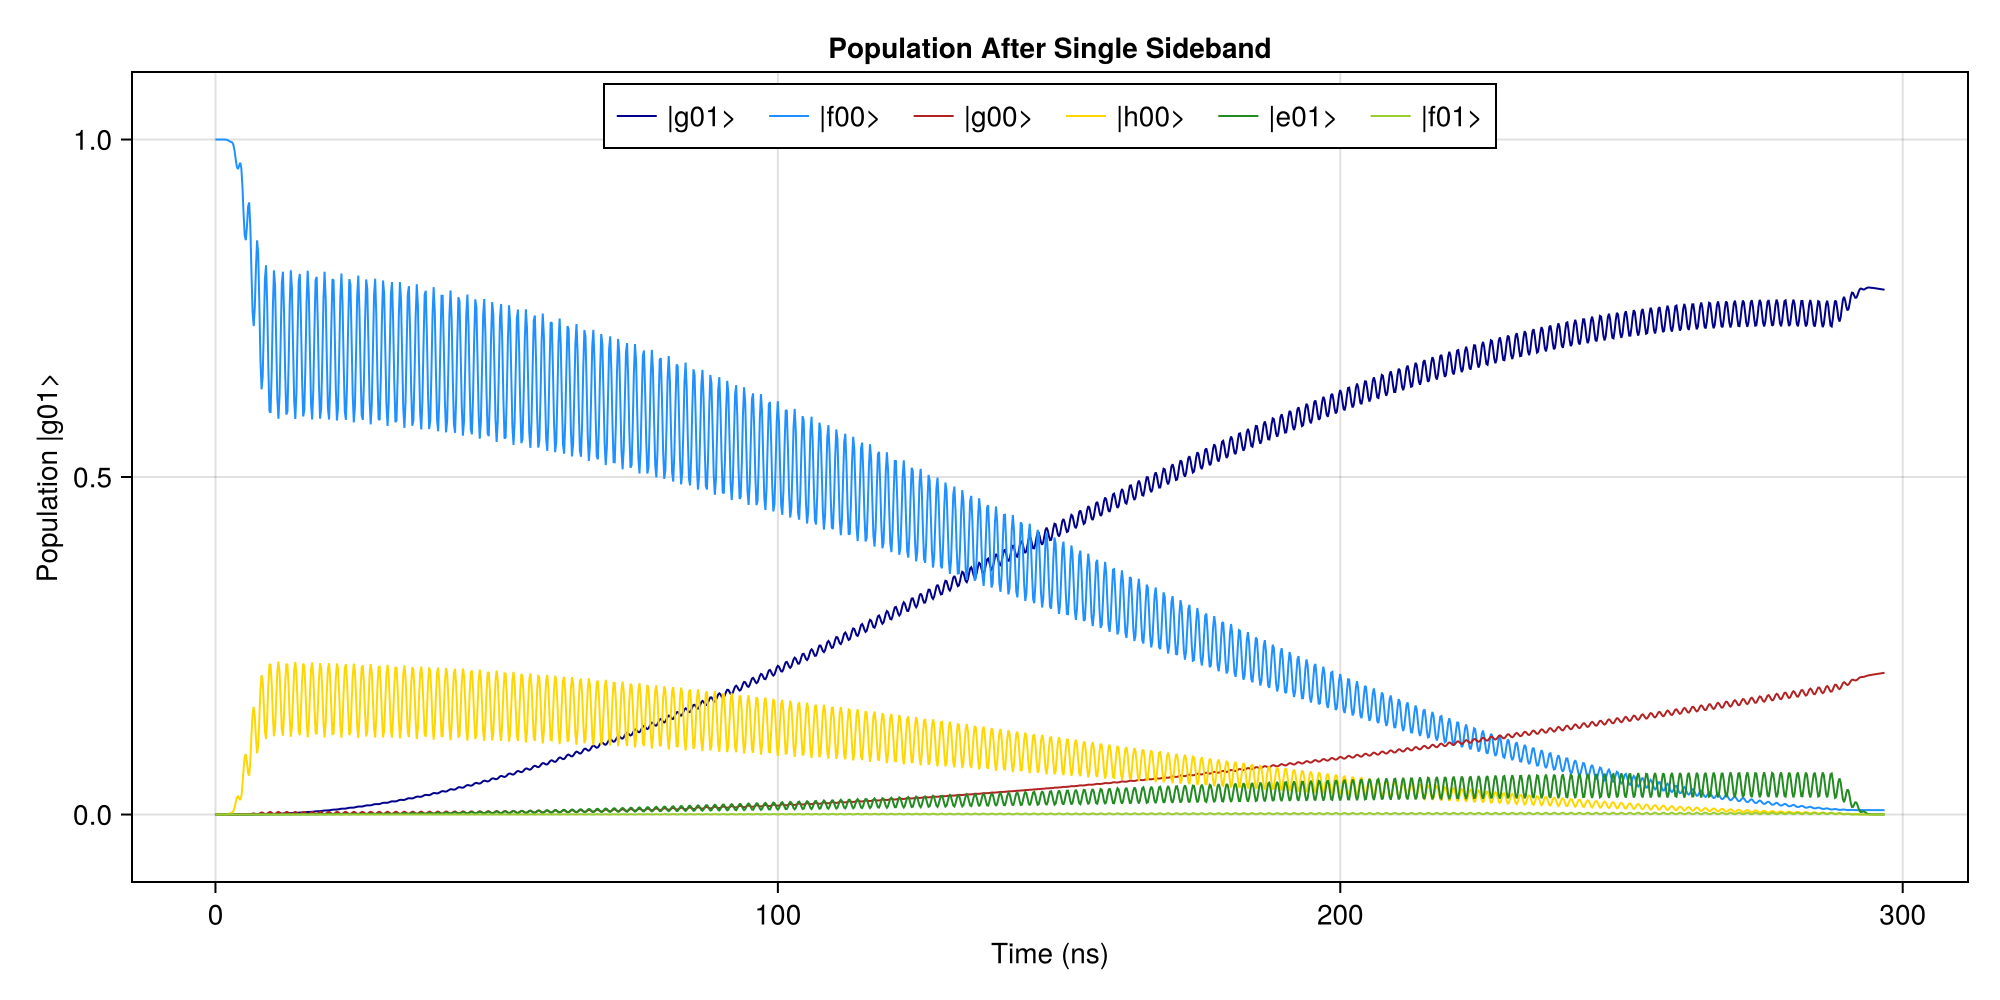

CairoMakie.Screen{IMAGE}


In [363]:
f = cm.Figure(size = (1000, 500))
ax = cm.Axis(f[1,1], title = "Population After Single Sideband", xlabel = "Time (ns)", ylabel = "Population |g01>", limits = (nothing, (-0.1,1.1)))

ms = 0.1
lw = 1
alpha = 0.3
y = [abs(qt.expect(run_res.states[i], Model.dressed_states[(0,0,1)])) for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "darkblue", label = "|g01>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(qt.expect(run_res.states[i],Model.dressed_states[(2,0,0)])) for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "dodgerblue", label = "|f00>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(qt.expect(run_res.states[i],Model.dressed_states[(0,0,0)])) for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "firebrick", label = "|g00>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(qt.expect(run_res.states[i],Model.dressed_states[(3,0,0)])) for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "gold", label = "|h00>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(qt.expect(run_res.states[i],Model.dressed_states[(1,0,1)])) for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "forestgreen", label = "|e01>", markersize = ms, alpha = alpha, linewidth = lw)
y = [abs(qt.expect(run_res.states[i],Model.dressed_states[(2,0,1)])) for i in 1:length(run_res.states)]
cm.scatterlines!(ax, run_res.times, y, color = "yellowgreen", label = "|f01>", markersize = ms, alpha = alpha, linewidth = lw)


cm.axislegend(ax, position = :ct, orientation = :horizontal)
display(f)